In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-01-24 17:12:46.434120: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-24 17:12:46.445416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737727966.458512   40679 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737727966.462146   40679 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-24 17:12:46.475262: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
train_dir = "./NEU Metal Surface Defects Data/train"
test_dir = "./NEU Metal Surface Defects Data/test"
valid_dir = "./NEU Metal Surface Defects Data/valid"

# Data preprocessing before modeling

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=20,
                             width_shift_range=0.1,
                             height_shift_range=0.1,
                             horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)


#get the images from train datagen
train_generator = train_datagen.flow_from_directory(train_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=True)
valid_generator = test_datagen.flow_from_directory(valid_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir,
                                              target_size=(200, 200),
                                              batch_size=32,
                                              class_mode='categorical',
                                              shuffle=False)

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


In [4]:
#checking for batch size
for image_batch , labels_batch in train_generator :
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 200, 200, 3)
(32, 6)


In [5]:
#checking for class names
class_names = train_generator.class_indices
class_names = list(class_names.keys())
print(class_names)

['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']


# Sample images 

In [6]:
#making functions
def get_sample_image(generator):
    images, labels = next(generator)
    image = images[0]
    label_index = np.argmax(labels[0])
    label_name = class_names[label_index]

    return image, label_name


def sample_images(generator, nrows=3, ncols=3):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 10))
    
    for i in range(nrows*ncols):
        image, label_name = get_sample_image(generator)
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]
        ax.imshow(image)
        ax.set_title(label_name)
        ax.axis('off')

    plt.show()

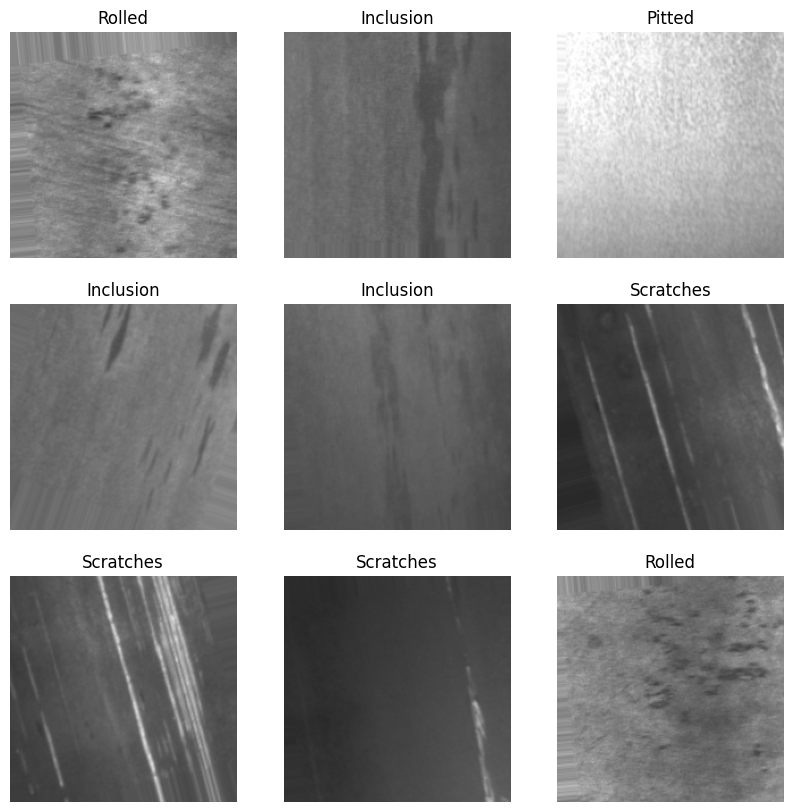

In [7]:
sample_images(train_generator, nrows=3, ncols=3)

In [8]:
image_batch

array([[[[0.4666667 , 0.4666667 , 0.4666667 ],
         [0.4666667 , 0.4666667 , 0.4666667 ],
         [0.46383643, 0.46383643, 0.46383643],
         ...,
         [0.4686628 , 0.4686628 , 0.4686628 ],
         [0.4722017 , 0.4722017 , 0.4722017 ],
         [0.46166375, 0.46166375, 0.46166375]],

        [[0.47829962, 0.47829962, 0.47829962],
         [0.47038195, 0.47038195, 0.47038195],
         [0.4666667 , 0.4666667 , 0.4666667 ],
         ...,
         [0.47130203, 0.47130203, 0.47130203],
         [0.46824285, 0.46824285, 0.46824285],
         [0.45902455, 0.45902455, 0.45902455]],

        [[0.50045687, 0.50045687, 0.50045687],
         [0.4925392 , 0.4925392 , 0.4925392 ],
         [0.48462152, 0.48462152, 0.48462152],
         ...,
         [0.47394127, 0.47394127, 0.47394127],
         [0.46428406, 0.46428406, 0.46428406],
         [0.4563853 , 0.4563853 , 0.4563853 ]],

        ...,

        [[0.4178972 , 0.4178972 , 0.4178972 ],
         [0.36988983, 0.36988983, 0.36988983]

# Deep learning model using CNN

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout
from tensorflow.keras.applications.efficientnet import EfficientNetB7

In [10]:
model1 = Sequential([ Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(6 ,activation='softmax')])

/home/cago/MECH536/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1737728085.888996   40679 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5677 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [11]:
model1.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [12]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
history = model1.fit(train_generator,
                    epochs=20,
                    batch_size=32,
                    validation_data=valid_generator)

/home/cago/MECH536/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1737728115.273877   41026 service.cc:148] XLA service 0x773244003d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737728115.273899   41026 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2025-01-24 17:15:15.295191: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1737728115.407332   41026 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-01-24 17:15:15.477703: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


 3/52 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.0625 - loss: 2.7460

I0000 00:00:1737728118.880925   41026 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


52/52 ━━━━━━━━━━━━━━━━━━━━ 14s 195ms/step - accuracy: 0.2231 - loss: 2.0781 - val_accuracy: 0.5278 - val_loss: 1.0366
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.7038 - loss: 0.8807 - val_accuracy: 0.8472 - val_loss: 0.5570
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.7391 - loss: 0.7402 - val_accuracy: 0.7500 - val_loss: 0.6691
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.8501 - loss: 0.4768 - val_accuracy: 0.8611 - val_loss: 0.3041
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.8552 - loss: 0.4096 - val_accuracy: 0.9306 - val_loss: 0.2455
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.8211 - loss: 0.5057 - val_accuracy: 0.9306 - val_loss: 0.2921
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.8702 - loss: 0.3419 - val_accuracy: 0.9583 - val_loss: 0.1305
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.8674 - loss: 0.3758 - val_accuracy: 0.9306 - val

# Model 1 Evaluate

In [14]:
def plot_history(history,metric):
    plt.plot(history.history[metric])
    plt.plot(history.history["val_"+metric],"")
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, "val_"+metric])
    plt.show()

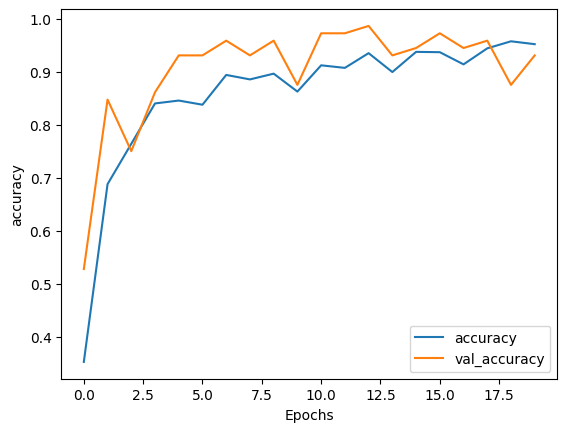

In [15]:
plot_history(history,"accuracy")

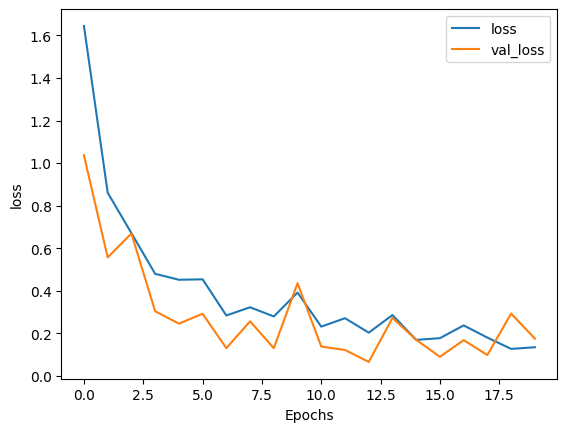

In [16]:
plot_history(history,"loss")

In [17]:
result = model1.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9596 - loss: 0.1363 
Test loss, Test accuracy :  [0.13883858919143677, 0.9583333134651184]


In [18]:
base_model = tf.keras.applications.efficientnet.EfficientNetB7(include_top = False , weights = 'imagenet' ,
                                                               input_shape = (200,200,3), pooling= 'max')
model2 = Sequential([ Conv2D(32, (2, 2), activation='relu', input_shape=(200, 200, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (2, 2), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(6 ,activation='softmax')])

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 138s 1us/step


/home/cago/MECH536/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])

In [20]:
model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 199, 199, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 99, 99, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 98, 98, 64)     │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 49, 49, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 128)    │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    18,874,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,917,734 (72.17 MB)

 Trainable params: 18,917,734 (72.17 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
history2 = model2.fit(train_generator,
                    epochs=20,
                    batch_size=32,
                    validation_data=valid_generator)

Epoch 1/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 124ms/step - accuracy: 0.2629 - loss: 2.4976 - val_accuracy: 0.4861 - val_loss: 1.3929
Epoch 2/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.5845 - loss: 1.0541 - val_accuracy: 0.8333 - val_loss: 0.6103
Epoch 3/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.7514 - loss: 0.6622 - val_accuracy: 0.7778 - val_loss: 0.5801
Epoch 4/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.8293 - loss: 0.4962 - val_accuracy: 0.7083 - val_loss: 1.0481
Epoch 5/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.8630 - loss: 0.3797 - val_accuracy: 0.9167 - val_loss: 0.1864
Epoch 6/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.8626 - loss: 0.3818 - val_accuracy: 0.8611 - val_loss: 0.3252
Epoch 7/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.8785 - loss: 0.3418 - val_accuracy: 0.7222 - val_loss: 0.7540
Epoch 8/20
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.8708 - loss: 0.3460 - val_accuracy: 0.

# Model 2 Evaluate

In [22]:
def plot_history(history, metric):
    plt.plot(history2.history[metric])
    plt.plot(history2.history['val_'+metric], '')
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])
    plt.show()

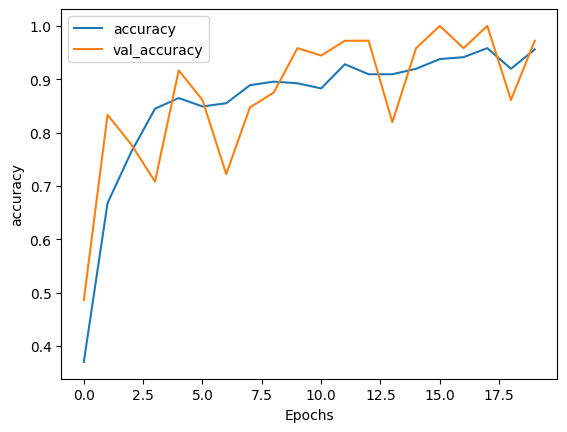

In [23]:
plot_history(history, 'accuracy')

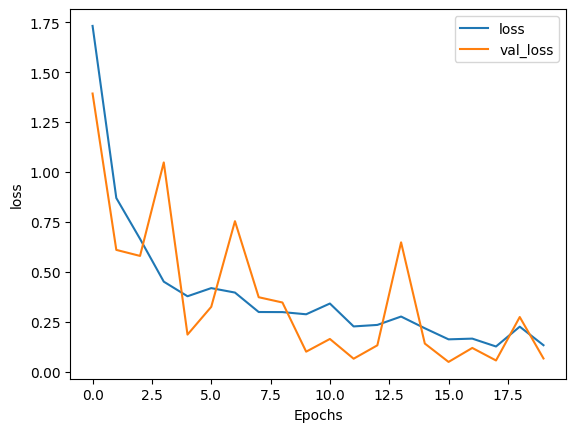

In [24]:
plot_history(history, 'loss')

In [25]:
result = model2.evaluate(test_generator)
print("Test loss, Test accuracy : ", result)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9427 - loss: 0.1369 
Test loss, Test accuracy :  [0.17122022807598114, 0.9166666865348816]


# Visualize Predicted Images

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step


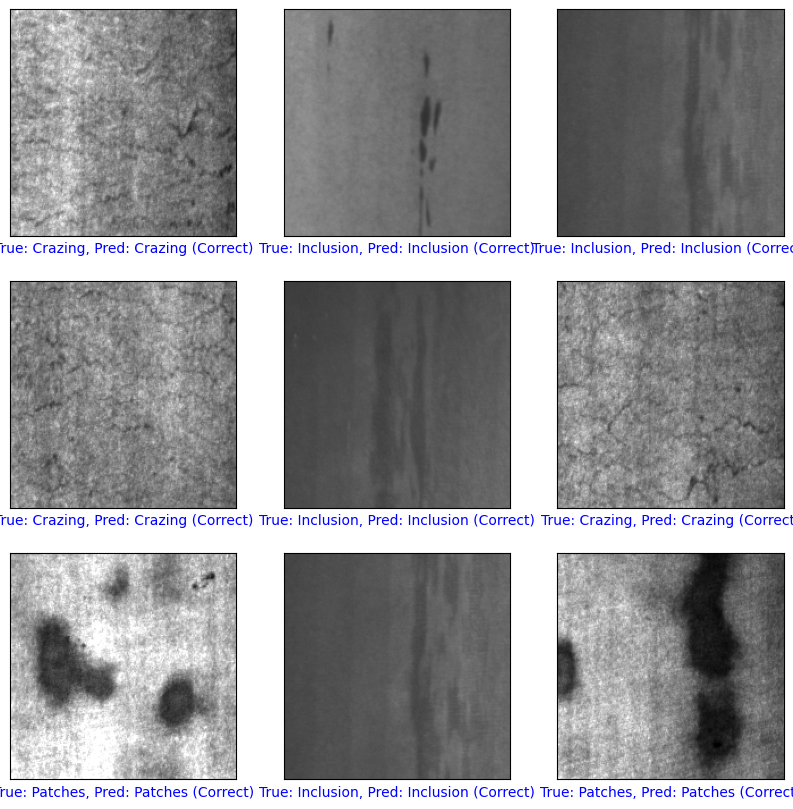

In [26]:
images, labels = next(test_generator)    

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = model1.predict(images)


class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(10,10))
    
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
        
    image = images[i]
        
    if image.shape[-1] == 1:
        image = np.squeeze(image) 
        
    plt.imshow(image)
        
    predicted_label = np.argmax(predictions[i])
        
    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"
            
    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"        
            
    plt.xlabel(label_text,color=color)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


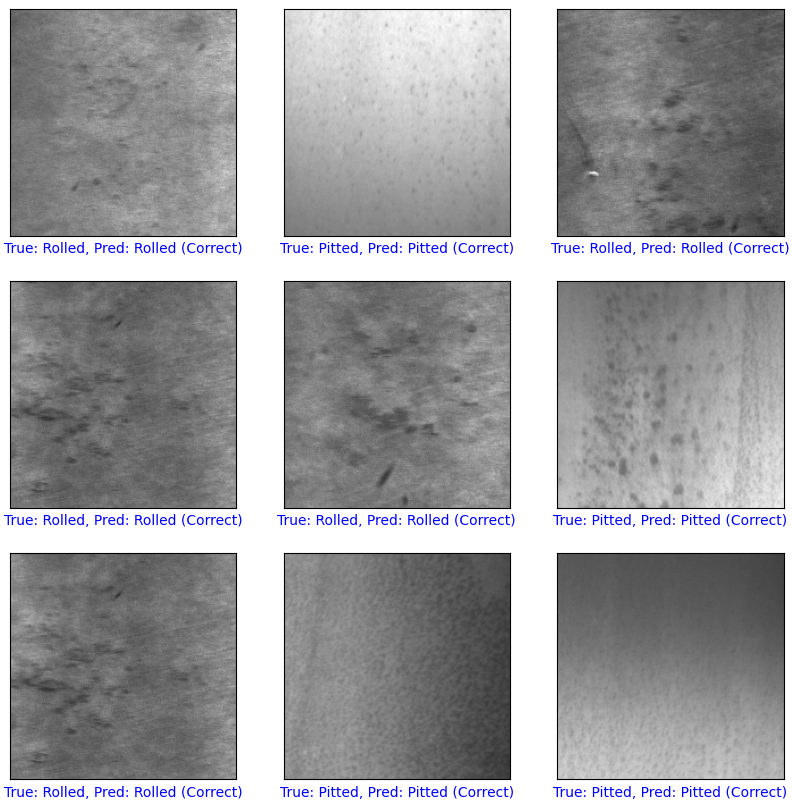

In [27]:
images, labels = next(test_generator)    

indices = np.random.choice(range(len(images)), size=9)
images = images[indices]
labels = labels[indices]

predictions = model2.predict(images)


class_names=list(test_generator.class_indices.keys())


plt.figure(figsize=(10,10))
    
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)model1.co
        
    image = images[i]
        
    if image.shape[-1] == 1:
        image = np.squeeze(image) 
        
    plt.imshow(image)
        
    predicted_label = np.argmax(predictions[i])
        
    if predicted_label == np.argmax(labels[i]):
        color='blue'
        result_text="Correct"
            
    else:
        color='red'
        result_text="Incorrect"

    label_text="True: "+ class_names[np.argmax(labels[i])] + ", Pred: " + class_names[predicted_label] + f" ({result_text})"        
            
    plt.xlabel(label_text,color=color)

# Comparing between two models

In [28]:
import pandas as pd

# Define the accuracy and loss values for both models
model1_accuracy = history.history['accuracy'][-1]
model1_loss = history.history['loss'][-1]
model2_accuracy = history2.history['accuracy'][-1]
model2_loss = history2.history['loss'][-1]


# Create a dictionary with the accuracy and loss values
data = {'Model': ['Model 1', 'Model 2'],
        'Accuracy': [model1_accuracy, model2_accuracy],
        'Loss': [model1_loss, model2_loss]}

df = pd.DataFrame(data)
df

,Model,Accuracy,Loss
0,Model 1,0.951691,0.134682
1,Model 2,0.955918,0.133237
